In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import requests

In [4]:
#dir = '/home/user/Desktop/Datos/'
dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [5]:
# Load data
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')
data = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01')]
del data_2019

In [6]:
def count_trips_mibici(data_user):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    return viajes_user

In [7]:
total_counter = count_trips_mibici(data)
total_counter

,Est_A,Est_B,counts,prob
0,2,2,83,0.000206
1,2,3,59,0.000146
2,2,4,26,0.000064
3,2,5,2,0.000005
4,2,6,23,0.000057
...,...,...,...,...
20711,294,295,7,0.000017
20712,294,296,33,0.000082
20713,295,295,33,0.000082
20714,295,296,26,0.000064


In [8]:
users_counts = data['Usuario_Id'].value_counts()
users = users_counts.index.tolist()

In [9]:
def compute_ps_ce(counter_user, total_counter):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    impurity: float with the impurity
    '''
    impurity = 0
    #print(impurity)
    for i in range(len(counter_user)):
        est_a = counter_user.iloc[i]['Est_A']
        est_b = counter_user.iloc[i]['Est_B']
        prob = counter_user.iloc[i]['prob']
        current_general = total_counter[(total_counter['Est_A'] == est_a) & (total_counter['Est_B'] == est_b)]
        impurity -= np.log(prob) * current_general['prob'].values[0]
        #print(impurity)
    return impurity

In [10]:
def compute_div_kl(counter_user, total_counter):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    divergence: float with the divergence
    '''
    divergence = 0
    #print(divergence)
    for i in range(len(counter_user)):
        est_a = counter_user.iloc[i]['Est_A']
        est_b = counter_user.iloc[i]['Est_B']
        prob = counter_user.iloc[i]['prob']
        current_general = total_counter[(total_counter['Est_A'] == est_a) & (total_counter['Est_B'] == est_b)]
        divergence += prob * np.log(prob / current_general['prob'].values[0])
        #print(divergence)
    return divergence

In [11]:
def compute_entropy(counter_user):
    '''
    args:
    counter_user: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by a specific user
    total_counter: DataFrame with columns Est_A, Est_B, counts, prob given by count_trips_mibici by all users
    return:
    entropy: float with the entropy
    '''
    entropy = 0
    for i in range(len(counter_user)):
        prob = counter_user.iloc[i]['prob']
        entropy -= prob * np.log(prob)
    return entropy

In [27]:
len(users)  

17433

In [12]:
n = 100

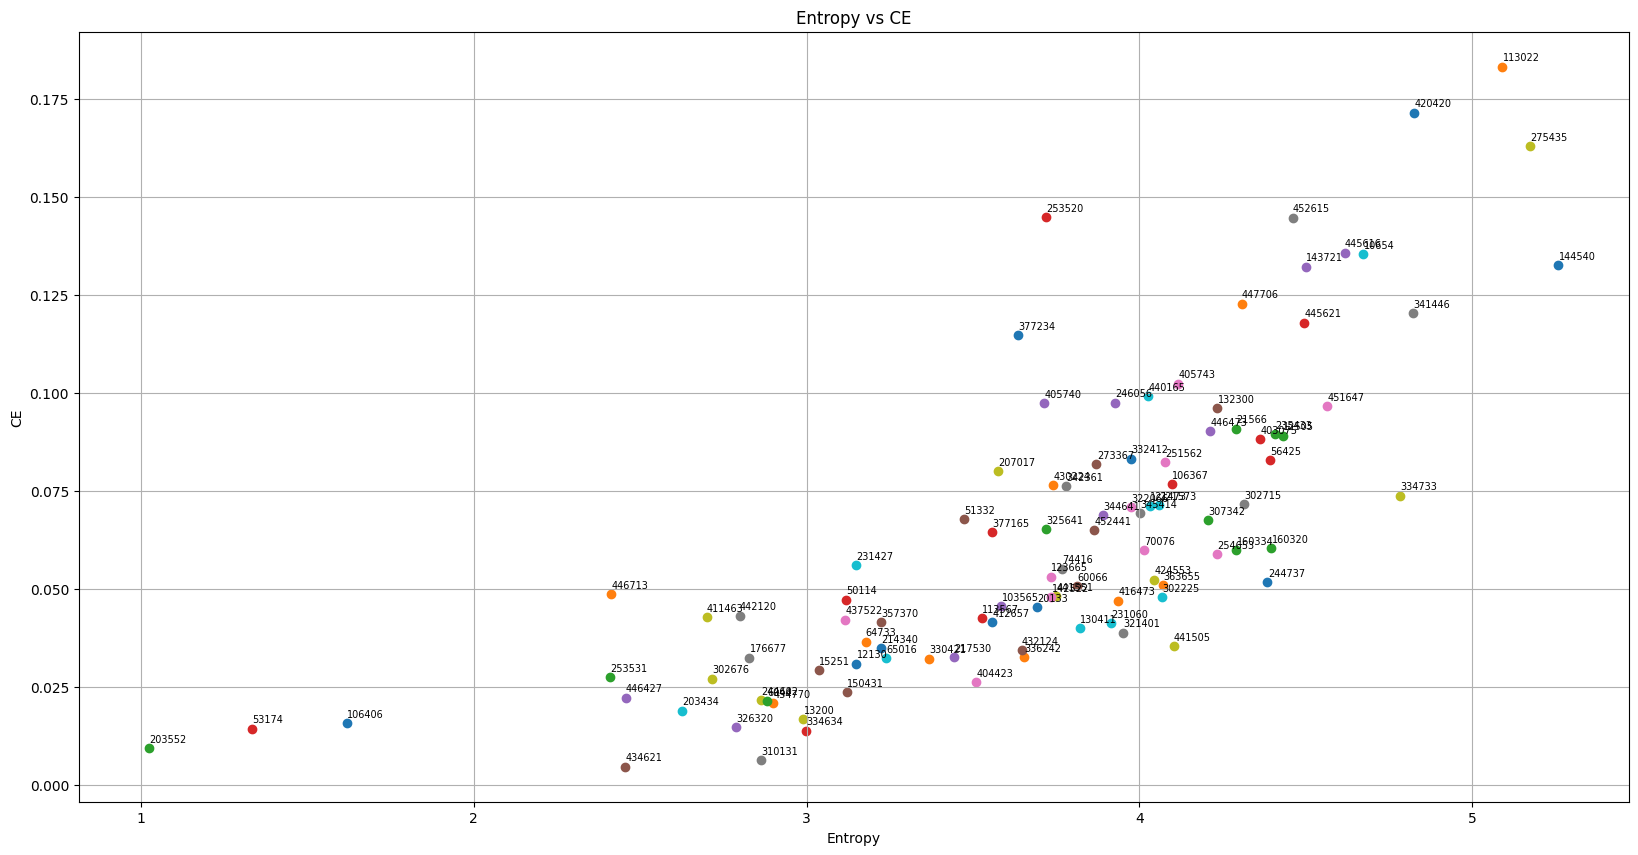

In [13]:
plt.figure(figsize=(20, 10))
for user in users[:n]:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    
    # Calcular la entropía y la impureza de PS para el usuario
    entropy = compute_entropy(counter_user)
    impurity = compute_ps_ce(counter_user, total_counter)
    
    # Graficar el punto del usuario
    plt.scatter(entropy, impurity, label=user)
    plt.text(entropy + 0.001, impurity + 0.001, str(user), fontsize=7, ha='left', va='bottom')  

plt.xlabel('Entropy')
plt.ylabel('CE')
plt.title('Entropy vs CE')
plt.grid()
plt.savefig(f'{dir}/entropy_vs_ce.png')
plt.show()


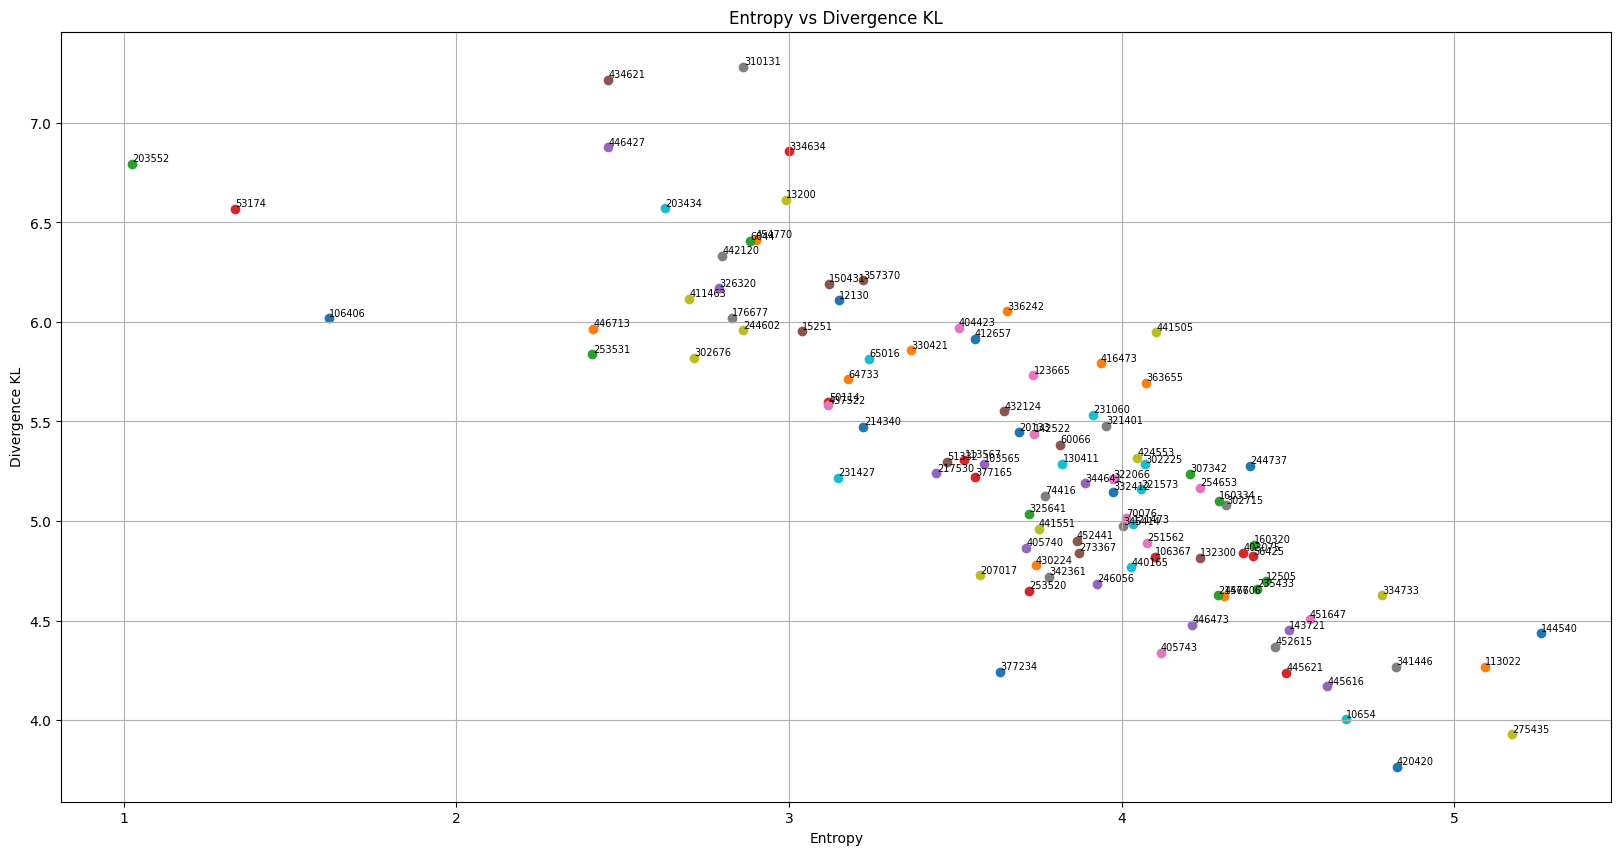

In [14]:
plt.figure(figsize=(20, 10))
for user in users[:n]:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    
    # Calcular la entropía y la impureza de PS para el usuario
    entropy = compute_entropy(counter_user)
    impurity = compute_div_kl(counter_user, total_counter)
    
    # Graficar el punto del usuario
    plt.scatter(entropy, impurity, label=user)
    plt.text(entropy + 0.001, impurity + 0.001, str(user), fontsize=7, ha='left', va='bottom')  

plt.xlabel('Entropy')
plt.ylabel('Divergence KL')
plt.title('Entropy vs Divergence KL')
plt.grid()
plt.savefig(f'{dir}/entropy_vs_div_kl.png')
plt.show()


In [15]:
projected_data = []
for user in users:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    if counter_user['counts'].sum() >= 10:
        # Calcular la entropía y la impureza de PS para el usuario
        entropy = compute_entropy(counter_user)
        impurity = compute_ps_ce(counter_user, total_counter)
        projected_data.append([entropy, impurity])

projected_data = np.array(projected_data)

In [16]:
labels = KMeans(n_clusters=3).fit_predict(projected_data)

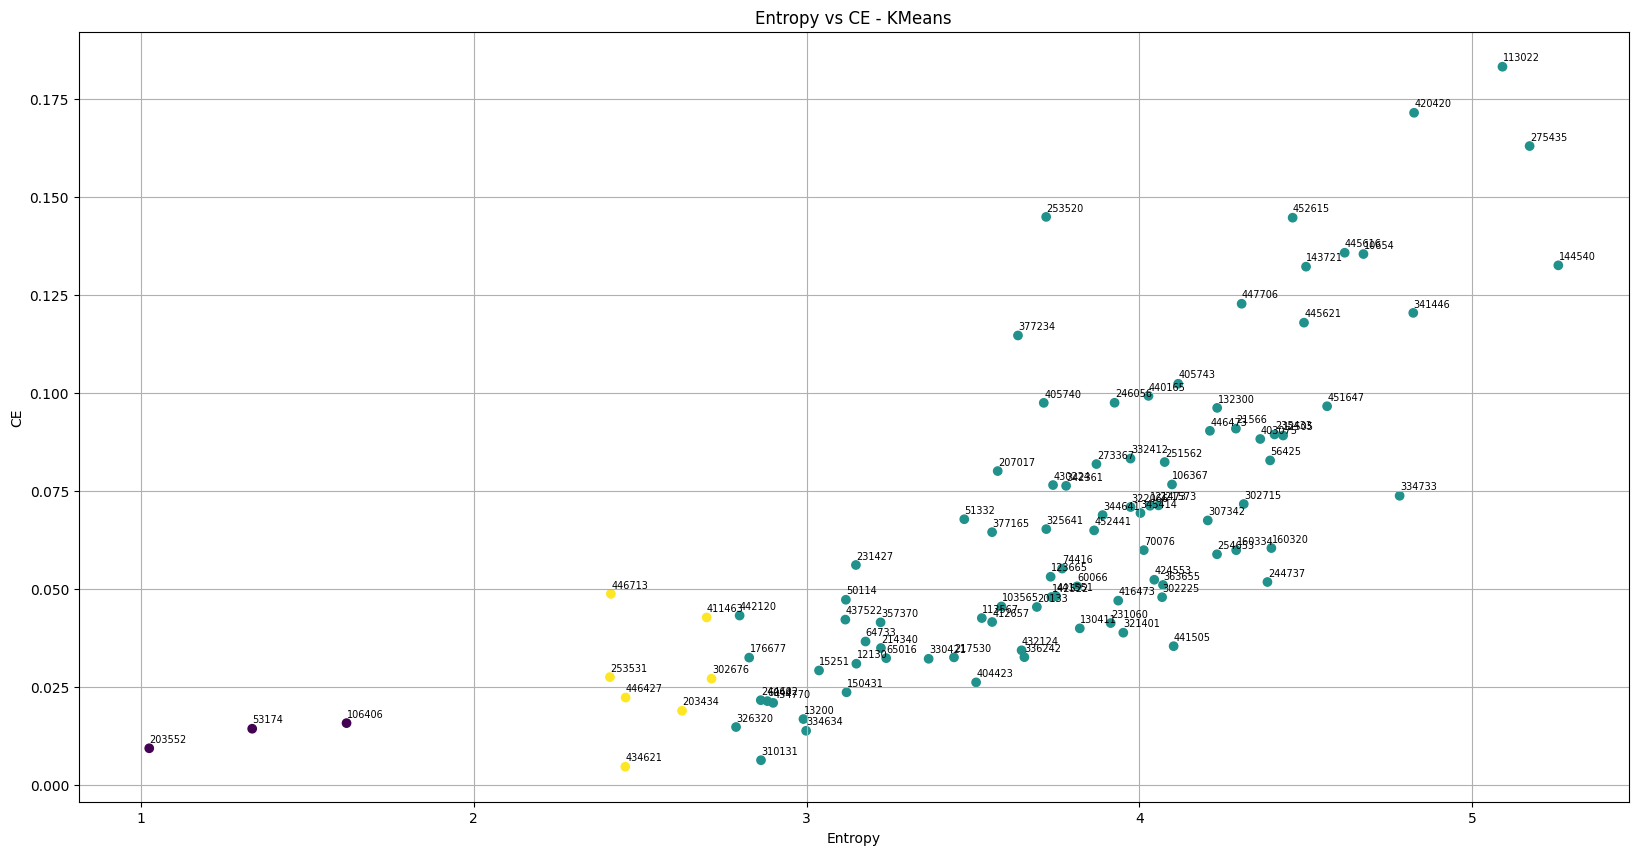

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(projected_data[0:n:, 0], projected_data[0:n:, 1], c=labels[:n], cmap='viridis')
for i in range(n):
    plt.text(projected_data[i, 0] + 0.001, projected_data[i, 1] + 0.001, str(users[i]), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropy')
plt.ylabel('CE')
plt.title('Entropy vs CE - KMeans')
plt.grid()
plt.savefig(f'{dir}/entropy_vs_ce_kmeans.png')
plt.show()

In [18]:
projected_data2 = []
for user in users:
    data_user = data[data['Usuario_Id'] == user]
    counter_user = count_trips_mibici(data_user)
    if counter_user['counts'].sum() >= 10:
        # Calcular la entropía y la impureza de PS para el usuario
        entropy = compute_entropy(counter_user)
        impurity = compute_div_kl(counter_user, total_counter)
        projected_data2.append([entropy, impurity])

projected_data2 = np.array(projected_data2)

In [19]:
labels2 = KMeans(n_clusters=3).fit_predict(projected_data2)

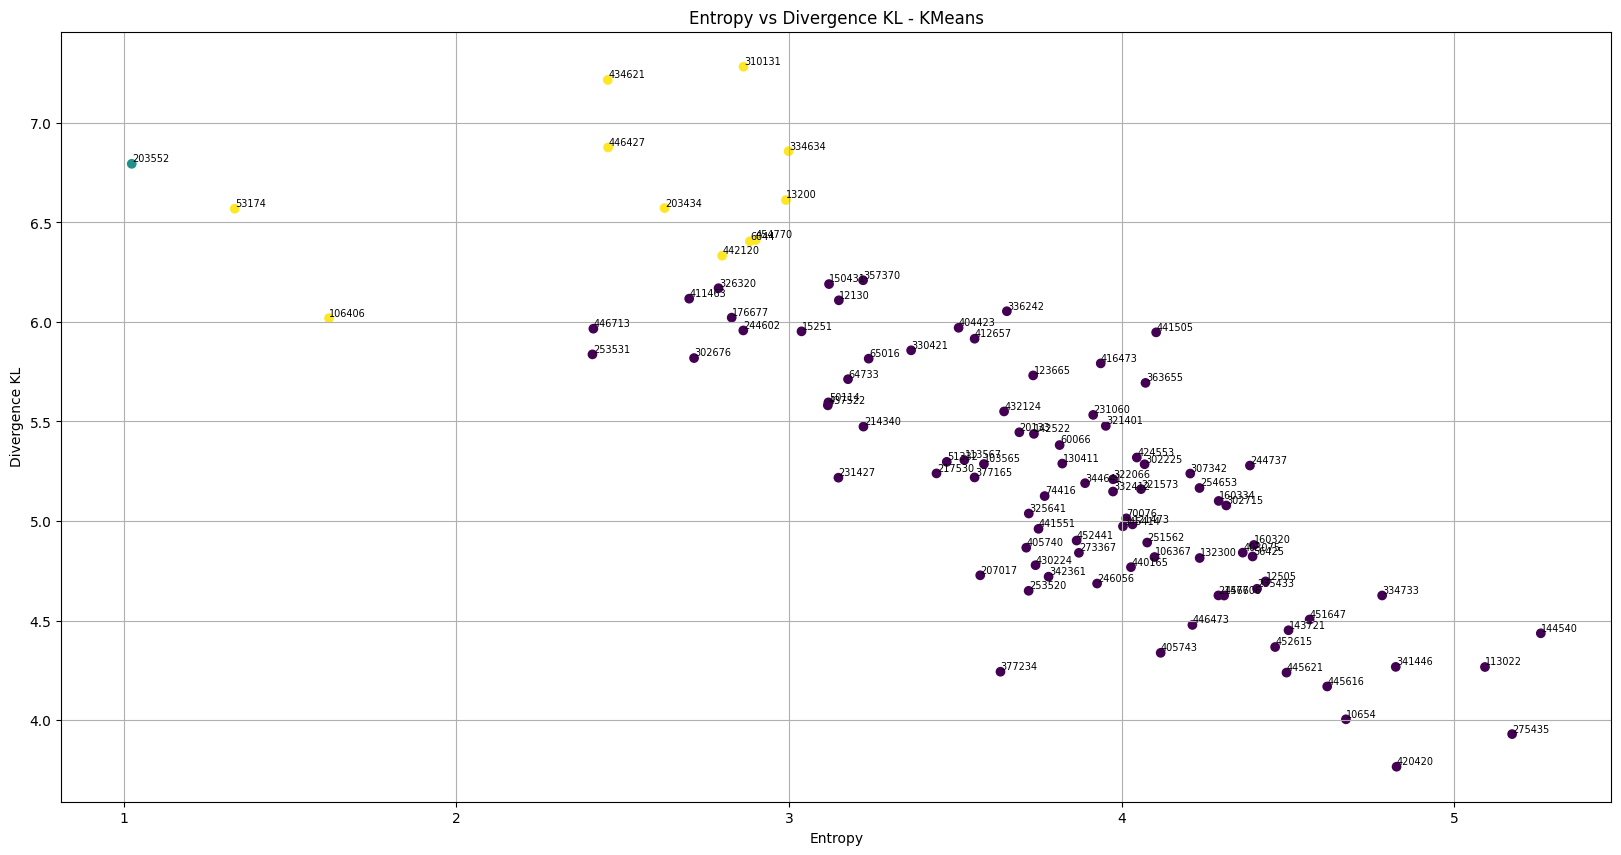

In [20]:
plt.figure(figsize=(20, 10))
plt.scatter(projected_data2[0:n:, 0], projected_data2[0:n:, 1], c=labels2[:n], cmap='viridis')
for i in range(n):
    plt.text(projected_data2[i, 0] + 0.001, projected_data2[i, 1] + 0.001, str(users[i]), fontsize=7, ha='left', va='bottom')
plt.xlabel('Entropy')
plt.ylabel('Divergence KL')
plt.title('Entropy vs Divergence KL - KMeans')
plt.grid()
plt.savefig(f'{dir}/entropy_vs_div_kl_kmeans.png')
plt.show()

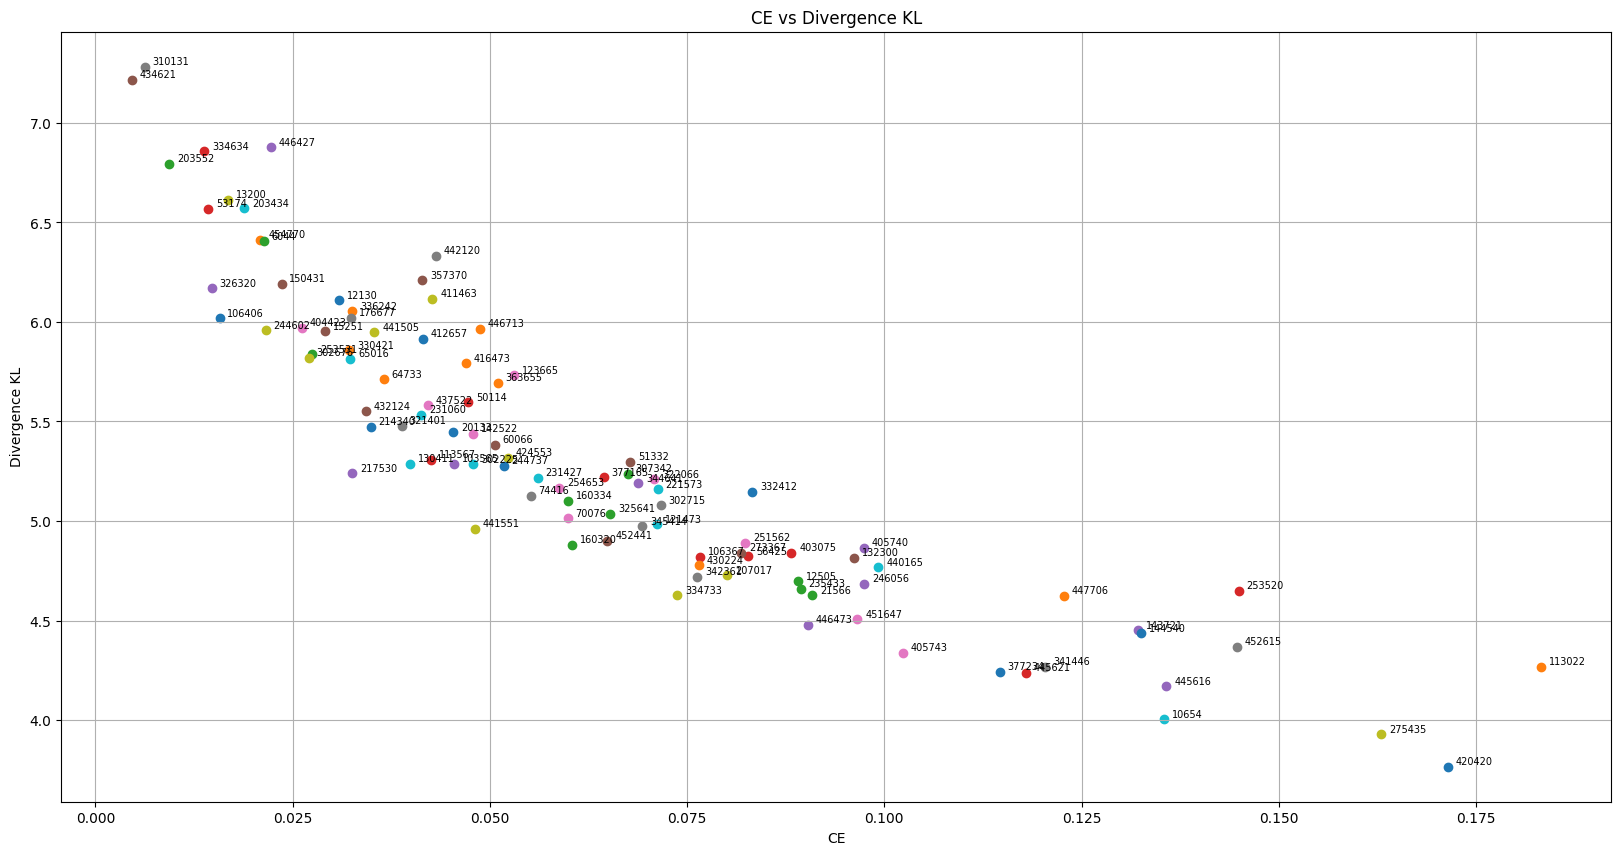

In [21]:
plt.figure(figsize=(20, 10))
for i in range(n):
    plt.scatter(projected_data[i, 1], projected_data2[i, 1])
    plt.text(projected_data[i, 1] + 0.001, projected_data2[i, 1] + 0.001, str(users[i]), fontsize=7, ha='left', va='bottom')
plt.xlabel('CE')
plt.ylabel('Divergence KL')
plt.title('CE vs Divergence KL')
plt.grid()
plt.savefig(f'{dir}/ce_vs_div_kl.png')
plt.show()

In [22]:
projected_data3 = []
for i in range(len(projected_data)):
    projected_data3.append([projected_data[i, 1], projected_data2[i, 1]])

projected_data3 = np.array(projected_data3)

In [23]:
labels3 = KMeans(n_clusters=3).fit_predict(projected_data3)

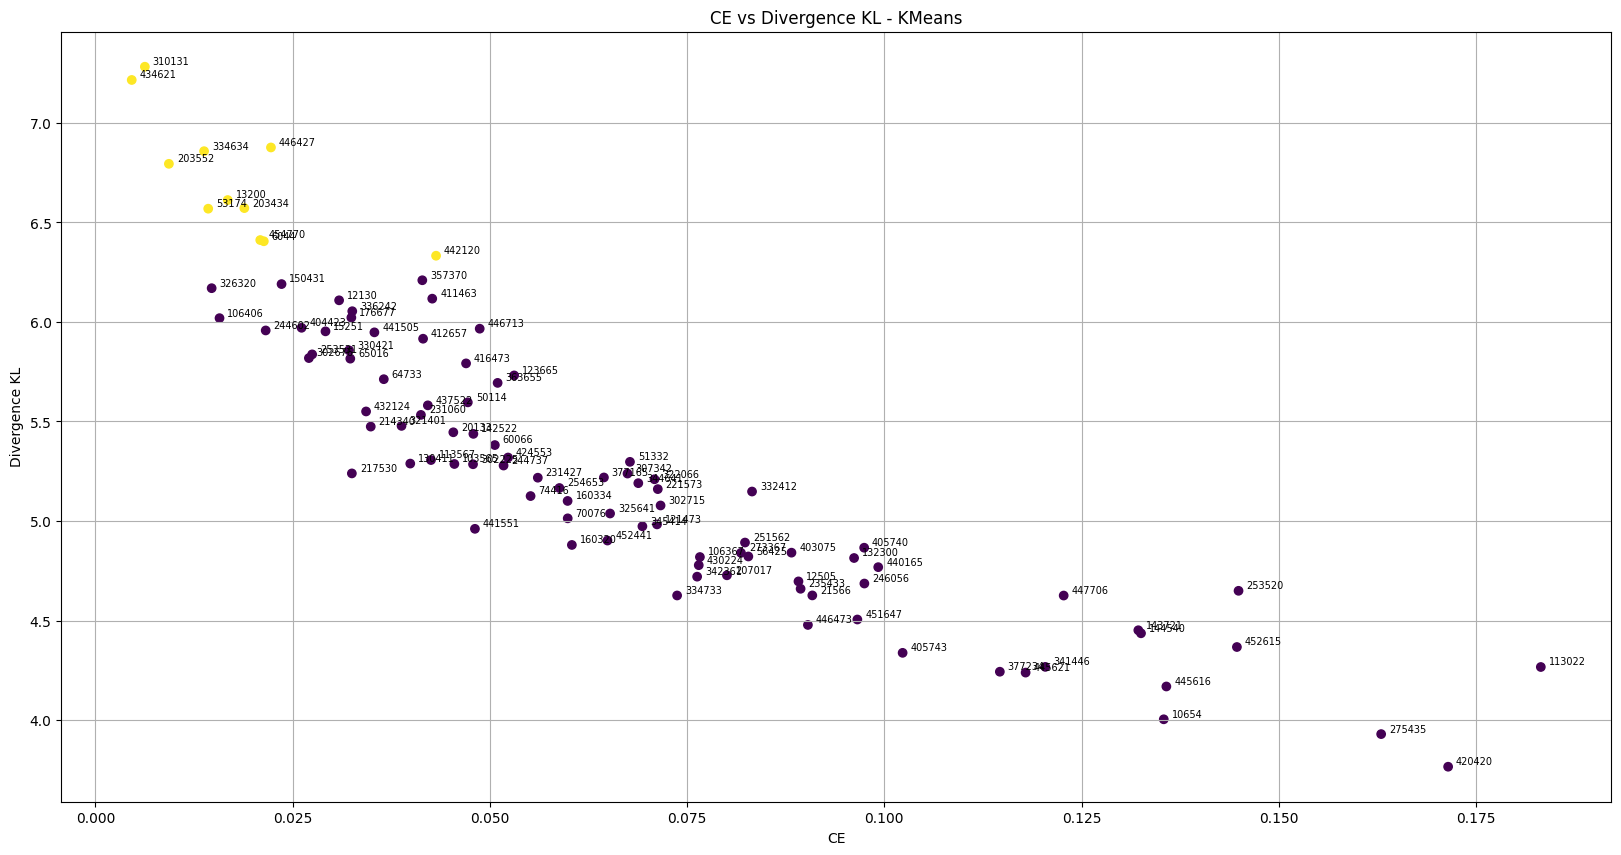

In [24]:
plt.figure(figsize=(20, 10))
plt.scatter(projected_data3[0:n:, 0], projected_data3[0:n:, 1], c=labels3[:n], cmap='viridis')
for i in range(n):
    plt.text(projected_data3[i, 0] + 0.001, projected_data3[i, 1] + 0.001, str(users[i]), fontsize=7, ha='left', va='bottom')
plt.xlabel('CE')
plt.ylabel('Divergence KL')
plt.title('CE vs Divergence KL - KMeans')
plt.grid()
plt.savefig(f'{dir}/ce_vs_div_kl_kmeans.png')
plt.show()

In [25]:
def send_message(message):
    requests.post("https://ntfy.sh/Compu_CIMAT",
        data=message.encode(encoding='utf-8'))

In [26]:
send_message("Terminé")